In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.io import wavfile
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from torchvision import transforms
import torchaudio.transforms as ta_transforms
import math
import torchaudio
import time
import random
from customdataset import *
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['KMP_DUPLICATE_LIB_OK']
PATH=os.getenv("HOME")+"/aiffel/ECG_data/physionet.org/files/circor-heart-sound/1.0.3/training_data"

In [2]:
cv2

<module 'cv2.cv2' from '/opt/conda/lib/python3.9/site-packages/cv2/cv2.cpython-39-x86_64-linux-gnu.so'>

In [28]:
file_list = os.listdir(PATH)
txt_list = [os.path.join(PATH, file) for file in file_list if file.endswith(".txt")]

# 환자 아이디를 훈련, 검증, 테스트 데이터셋으로 나눔
train_patient_txt, extra_patient_txt = train_test_split(txt_list, test_size=0.4, random_state=42)
valid_patient_txt, test_patient_txt = train_test_split(extra_patient_txt, test_size=0.5, random_state=42)

print(len(txt_list) ,len(train_patient_txt),
      len(valid_patient_txt) ,len(test_patient_txt)
     )

942 565 188 189


In [29]:
print(test_patient_txt[0]) 
test_patient_txt=[test_patient_txt[0]]

/aiffel/aiffel/ECG_data/physionet.org/files/circor-heart-sound/1.0.3/training_data/50649.txt


In [76]:
SAMPLE_RATE = 4000
HOP_LENGTH = int(np.ceil(SAMPLE_RATE*0.01))#시간
WIN_LENGTH = int(np.ceil(SAMPLE_RATE / 40))#주파수
_length = WIN_LENGTH - 1

n=0
while _length > 1:
    _length = _length // 2
    n+=1
N_FFT = 2 ** (n+1)
N_MELS = 128 #300 if N_FFT // 2 + 1 > 300 else N_FFT // 2 + 1
print(N_FFT,WIN_LENGTH)

128 100


In [77]:
#SAMPLE_RATE = 4000
#HOP_LENGTH = 40
#N_MELS = 256
#N_FFT = 1024
#WIN_LENGTH = 533

In [78]:
s_t=time.time()
filters = [
    (0, 400, SAMPLE_RATE, 1.0),
    (1, 25, SAMPLE_RATE, 1.0),
    (2, 125, SAMPLE_RATE, 1.0),
    (3, 125,SAMPLE_RATE, 1.0),
    (4, 125, SAMPLE_RATE, 1.0, 1.0),
    (5, 200, SAMPLE_RATE, 1.0, 1.0),
    (6, 125, SAMPLE_RATE, 1.0, 1.0)
]
dataset = CustomDataset(PATH, test_patient_txt,
                        sample_rate=SAMPLE_RATE,
                        hop_length=HOP_LENGTH,
                        n_mels=N_MELS,
                        n_fft=N_FFT,
                        win_length=WIN_LENGTH,
                        filter_params = [filters[1], filters[0]],
                        padding_type=0,
                        multi_channels=True, clipping=True)
#train_dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True, collate_fn=my_collate_fn)
e_t=time.time()

print(e_t-s_t)

data:  25
label:  25
0.46839046478271484


In [8]:
!pip install --upgrade librosa==0.10.1

     |████████████████████████████████| 253 kB 7.8 MB/s            
     |████████████████████████████████| 1.2 MB 73.5 MB/s            
     |████████████████████████████████| 1.2 MB 67.7 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.1
    Uninstalling typing-extensions-4.0.1:
      Successfully uninstalled typing-extensions-4.0.1
  Attempting uninstall: soundfile
    Found existing installation: SoundFile 0.10.3.post1
    Uninstalling SoundFile-0.10.3.post1:
      Successfully uninstalled SoundFile-0.10.3.post1
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is in

In [9]:
librosa.__version__

'0.8.1'

torch.Size([3, 300, 300])
torch.Size([3, 300, 300])


<Figure size 504x504 with 0 Axes>

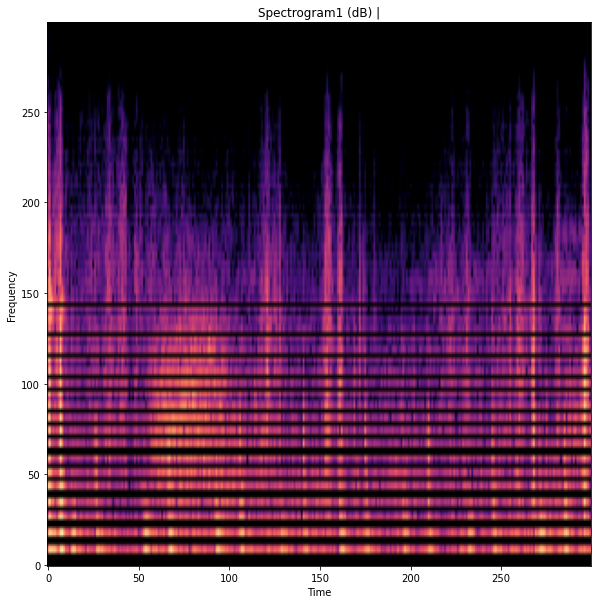

<Figure size 504x504 with 0 Axes>

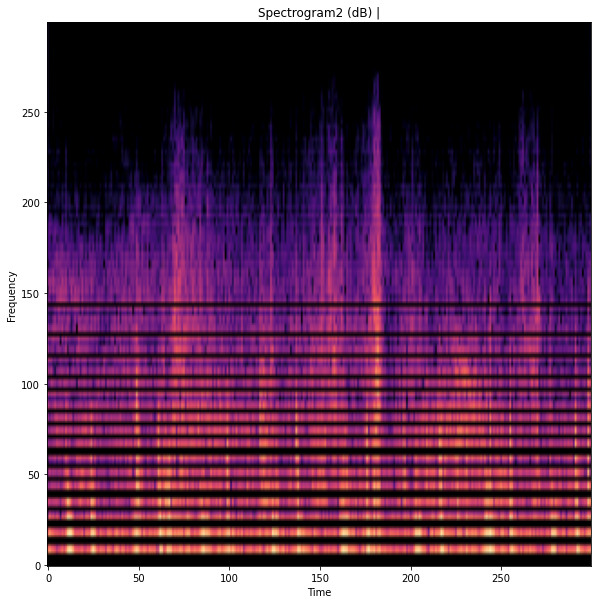

In [79]:
from matplotlib.patches import Rectangle

for i, d in enumerate(dataset):
    if i == 2: # 20개만 출력
        break
    x, y = d
    plt.figure(figsize=(7,7))
    fig, ax = plt.subplots(figsize=(10, 10))
    # 스펙트로그램 시각화
    print(x.shape)
    if x.shape[0] == 3:
        
        x = np.transpose(np.array(x), (1, 2, 0))
        ax.imshow(cv2.cvtColor(np.array(x), cv2.COLOR_BGR2RGB), origin='lower')
        
        '''
        librosa.display.specshow(cv2.cvtColor(x), cv2.COLOR_BGR2RGB),
                                 sr=SAMPLE_RATE,
                                 hop_length=HOP_LENGTH,
                                 n_fft=N_FFT,
                                 win_length=WIN_LENGTH,
                                 cmap='magma')
        '''
        
    else:
        ax.imshow(np.array(x[0]), cmap=plt.cm.gray)
        '''
        librosa.display.specshow(np.array(x[0]),
                                 sr=SAMPLE_RATE,
                                 hop_length=HOP_LENGTH,
                                 n_fft=N_FFT,
                                 win_length=WIN_LENGTH,
                                 cmap='magma')
        '''

    # 레이블 시각화
    for label in y:
        start, _, end, height, class_id= label
        start *= 300    # 300 = output 이미지 가로 크기
        end *= 300      # 300 = output 이미지 가로 크기
        height *= 300   # 300 = output 이미지 세로 크기
        color = 'red' if class_id == 1 else 'blue'
        ax.add_patch(Rectangle((start, 0), (end - start), height,
                               edgecolor = color,
                               facecolor = 'white',
                               fill=True,
                               alpha=0.5,
                               lw=3))

    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.title(f"Spectrogram{i + 1} (dB) |")# clipping row={height/300}")

In [47]:
a=[[1,2],[3,4],[5,6]]

for t in a[0][1]:
    print(t)

TypeError: 'int' object is not iterable

In [17]:
a[:][:][1]

[3, 4]

In [18]:
for x in range(1,10):
    print(x)

1
2
3
4
5
6
7
8
9
